# Image Segmentation: first steps


<a href="https://colab.research.google.com/github/oriflamms/LivreQuanti2023/blob/main/DataModelling/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!yolo predict model=yolov8s.pt source='https://iiif.irht.cnrs.fr/iiif/ark:/63955/vbeojj64ek6s/1516,690,864,1388/full/0/default.jpg'

# Printers and booksellers of books of hours as a network (Export edges)

In the variable "new_data2", we have a list of dictionaries describing each edition with the information "place", "printer", "bookseller", "date", "GWids" if they exist. 
The following cell creates a list of "edges", with each couple "printer+bookseller", the number of occurrences, the list of GWids and the list of dates, both separated by the character "|".

In [13]:
import csv

# Sample list of dictionaries
list_of_dicts = new_data2

# Create a CSV file with the specified columns
csv_file_path = 'output.csv'

# Create a CSV file with the specified columns and delimiter
csv_file_path = 'output.csv'

with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['printer', 'bookseller', 'weight', 'GWids', 'date', 'place']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')

    # Write the header to the CSV file
    writer.writeheader()

    # Create a dictionary to keep track of weights and other values
    data_dict = {}

    # Iterate through the list of dictionaries
    for entry in list_of_dicts:
        printer = entry.get('printer', '')
        bookseller = entry.get('bookseller', '')
        gwids = entry.get('GWids', '')
        date = entry.get('date', '')
        place = entry.get('place', '')

        # Calculate the weight based on the combination of 'printer' and 'bookseller'
        key = (printer, bookseller)
        data_key = (printer, bookseller, gwids, date)
        data_dict.setdefault(key, {'weight': 0, 'GWids': set(), 'date': set(), 'place': set()})

        # Increment the weight and add GWids, date, and place to the sets
        data_dict[key]['weight'] += 1
        data_dict[key]['GWids'].add(gwids)
        data_dict[key]['date'].add(date)
        data_dict[key]['place'].add(place)

    # Write the grouped data to the CSV file
    for (printer, bookseller), values in data_dict.items():
        writer.writerow({
            'printer': printer,
            'bookseller': bookseller,
            'weight': values['weight'],
            'GWids': '|'.join(values['GWids']),
            'date': '|'.join(values['date']),
            'place': '|'.join(values['place'])
        })

print(f"CSV file '{csv_file_path}' has been created.")


CSV file 'output.csv' has been created.


## graph

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
# Load your CSV file into a DataFrame
# The CSV file should have two columns, let's call them 'Node1' and 'Node2'
# Each row represents an edge between Node1 and Node2
csv_file_path = './output.csv'  # Replace with the path to your CSV file
df = pd.read_csv(csv_file_path, sep=';')
df

,printer,bookseller,weight,GWids,date,place
0,ohne Drucker,NaN,11,Sp. 487a|Sp. 674a|Sp. 654a|Sp. 712a|13321|1294...,|1488|um 1500|um 1494(?)|nicht vor 1493|um 147...,Antwerpen|Rouen|Paris|Deutschland(?)|Florenz|V...
1,Adriaan van Liesveldt,NaN,6,13419|13404|13406|13421|13422|13405,9.VIII.1494|1498(?)|22.VI.1494|29.VII.1495|13....,Antwerpen
2,Govert Bac,NaN,2,13418|13420,nicht vor 1493|1495,Antwerpen
3,Gerard Leeu,NaN,6,13417|13400|13399|13403|13413|13401,um 1483/84|13.III.1492|14 87|1487|27.VII.1489|...,Antwerpen|Gouda
4,Gerard Leeu oder Adriaan van Liesveldt,NaN,1,13402,"nicht vor 30.IV.1491, nicht nach 1492 oder nic...",Antwerpen
...,...,...,...,...,...,...
218,Julian Notary,NaN,1,13028,2.IV.1500,Westminster
219,Wynkyn de Worde auf Veranlassung von Elisabeth...,NaN,1,13025,um 1493,Westminster
220,Wynkyn de Worde,NaN,2,13026|13027,um 1493/94|um 1494,Westminster
221,Georg Coci und Genossen,NaN,1,13446,30.VII.1500,Zaragoza


The created dataframe contains many rows with "NaN" values, most of times when there is no bookseller information, sometimes when there is no printer information. We will filter out this rows.

In [16]:
filtered_df = df.dropna(subset=['printer', 'bookseller'])
filtered_df

,printer,bookseller,weight,GWids,date,place
42,"Julian Notary, Jean Barbier und I. H.",Wynkyn de Worde,1,13017,3.IV.1497,London
54,Nicolaus de Benedictis,Boninus de Boninis,2,13038|13037,20.III.1499|20.V.1499,Lyon
56,Jacobinus Suigus und Nicolaus de Benedictis,Boninus de Boninis,1,Sp. 429a,26.VIII.1500 vielmehr 1501,Lyon
68,Martin von Amsterdam,Andreas Ihyracensis,1,13350,27.I.1499,Neapel
71,Christian Preller,Antoine Gontier,1,13343,9.IV.1490,Neapel
...,...,...,...,...,...,...
201,Johann Hamann,Gerard Barrevelt und Frederick Egmondt,1,13377,1494,Venedig
202,Johann Hamann,Johann Volkarth,1,13380,14.XI.1495,Venedig
203,Johann Hamann,Octavianus Scotus,1,13385,1.X.1497,Venedig
205,Nicolas Jenson,? Raphael Zovenzonius,1,13357,um 1475,Venedig


Number of nodes: 87
Number of edges: 72


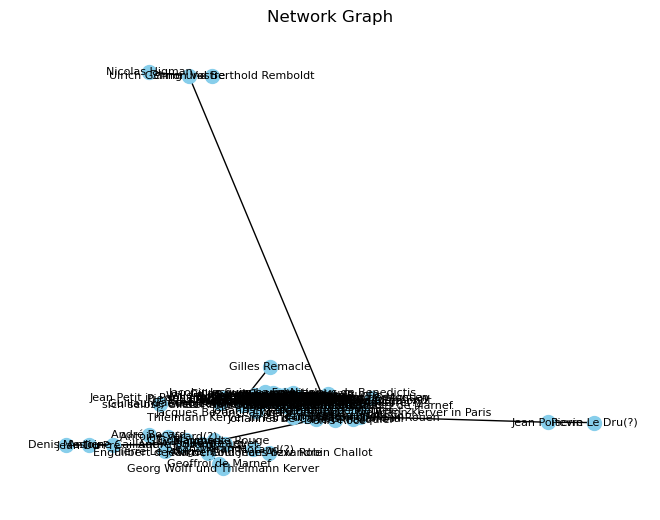


Degree Centrality:
Node Julian Notary, Jean Barbier und I. H.: 0.0116
Node Wynkyn de Worde: 0.0116
Node Nicolaus de Benedictis: 0.0116
Node Boninus de Boninis: 0.0233
Node Jacobinus Suigus und Nicolaus de Benedictis: 0.0116
Node Martin von Amsterdam: 0.0116
Node Andreas Ihyracensis: 0.0116
Node Christian Preller: 0.0116
Node Antoine Gontier: 0.0116
Node Friedrich Peypus: 0.0116
Node Johann Koberger: 0.0116
Node Guillaume Anabat: 0.0116
Node Gilles und Germain Hardouyn: 0.0116
Node André Bocard: 0.0233
Node Antoine Vérard(?): 0.0233
Node André Bocard(?): 0.0116
Node Antoine Vérard: 0.1279
Node Antoine Caillaut: 0.0233
Node Antoine Chappiel: 0.0116
Node Germain Hardouyn: 0.0116
Node Jean Du Pré: 0.0349
Node Denis Meslier: 0.0116
Node Ulrich Gering und Berthold Remboldt: 0.0116
Node Simon Vostre: 0.0349
Node Johann Higman: 0.0116
Node Willem Houtmaert in Antwerpen: 0.0116
Node Nicolas Higman: 0.0116
Node Etienne Jehannot: 0.1047
Node Johannes de Campis in Cambrai: 0.0116
Node Pierre Regn

In [17]:
# Create an empty graph
G = nx.Graph()

# Add edges from the DataFrame to the graph

# G.add_edges_from(filtered_df[['printer', 'bookseller']].values)
G.add_weighted_edges_from(filtered_df[['printer', 'bookseller', 'weight']].values)

# Print basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Draw the network graph
pos = nx.kamada_kawai_layout(G)  # You can use different layout algorithms 
                                            #spring_layout 
                                            #fruchterman_reingold_layout 
                                            #kamada_kawai_layout
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=8)
plt.title('Network Graph')
plt.show()

# Perform network analysis
degree_centrality = nx.degree_centrality(G)
print("\nDegree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"Node {node}: {centrality:.4f}")

# You can explore more network analysis metrics and functions provided by NetworkX
# For example, betweenness_centrality, closeness_centrality, etc.

Creating an interactive graph

plotly :  5.9.0


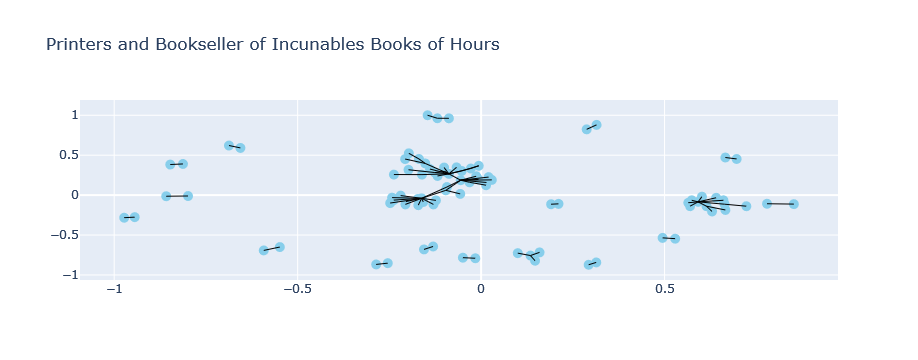

In [21]:

import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
print("plotly : ", plotly.__version__)


# Compute node positions using the spring layout algorithm
pos = nx.spring_layout(G)

# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure using go.Scatter
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        mode='markers',
        marker=dict(size=10, color='skyblue'),
        text=node,
        hoverinfo='text'
    ))

# Add edges to the figure using go.Scatter
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    fig.add_trace(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(color='black', width=1),
        hoverinfo='none'
    ))

# Set layout options
fig.update_layout(
    showlegend=False,
    title='Printers and Bookseller of Incunables Books of Hours',
    hovermode='closest'
)

# Show the figure
fig.show()


# Write the figure to an HTML file
pio.write_html(fig, file='GW-Printers-Booksellers-interactive_network_graph.html')